In [1]:
main_dir = 'project_code/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)

## Functions

### analysis functions

In [2]:
import numpy as np
def trial_randomize(istim, seed=None):
    unique_istims = np.unique(istim)
    num_unique_istims = len(unique_istims)

    # Set the random seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)

    label_values = {}
    for s_idx in range(num_unique_istims):
        s = unique_istims[s_idx]
        loc = np.where(istim == s)[0]
        label_values[s_idx]=list(loc)

    # Shuffle values within each label group
    for label in label_values:
        np.random.shuffle(label_values[label])

    # Reconstruct the shuffled data while maintaining the label order
    shuffled_data = [label_values[label].pop(0) for label in istim]

    return shuffled_data



#### time offset 

In [88]:
from macaque_data_functions import get_img_resp_avg_sem
def get_resps_mini(ref_resp, condition_type, date, ref_on, ref_off, w_size=25, spont_stim_off=300):
    if 'spont' in condition_type:
        chunk_size=int(spont_stim_off/w_size)
    else:
        chunk_size=None
    chunks = get_img_resp_avg_sem(ref_resp, date, condition_type, get_chunks=True, w_size=w_size, chunk_size=chunk_size)
    chunks_isolated = chunks[:,ref_on:ref_off, :]
    resp_mini = chunks_isolated.reshape(-1,ref_resp.shape[1])
    return resp_mini

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 
    
import random
# Set a seed for reproducibility (optional)
random.seed(17)  # You can use any integer value as the seed
# Generate 10 random seed numbers
seeds = [random.randint(1, 1000) for _ in range(10)]

def get_simil_reli_indices(reli1, reli1_indices, reli2, reli2_indices, seed):
    new_array1_indices = []

    array1= reli1[reli1_indices]
    array2=reli2[reli2_indices]
    
    for reli_val2 in array2:
        array1_vals = []
        tolerance = 0.001
        count=0
        for a1, reli_val1 in enumerate(array1):
            if np.isclose(reli_val2, reli_val1, atol=tolerance) and a1 not in new_array1_indices:
                count =+1
                array1_vals.append(a1)  
        while count==0:
            print(f'{tolerance} didnt work')
            tolerance *= 2
            for a1, reli_val1 in enumerate(array1):
                if np.isclose(reli_val2, reli_val1, atol=tolerance) and a1 not in new_array1_indices:
                    count =+1
                    array1_vals.append(a1)
        np.random.seed(seed)
        new_array1_indices.append(np.random.choice(array1_vals))
    return reli1_indices[new_array1_indices], reli2_indices

def store_V1_indices(monkey_stats, condition_types = ['SNR','RF_thin','RF_large']):
    area='V4'
    area2='V1'
    for condition_type in condition_types:
        for date in monkey_stats[condition_type]:
            reli = monkey_stats[get_property_dataset_type_monkey(condition_type)][date][area]['split_half_r']
            reli2 = monkey_stats[get_property_dataset_type_monkey(condition_type)][date][area2]['split_half_r']
            V4_filtered_indices = np.argwhere(reli > 0.8)[:,0]
            V1_filtered_indices = np.argwhere(reli2 > 0.8)[:,0]
            n_neurons = len(V4_filtered_indices)
            V1_chosen_indices = np.empty((len(seeds), n_neurons), dtype=int)
            for s, seed in enumerate(seeds):
                V1_chosen_indices[s], _= get_simil_reli_indices(reli2, V1_filtered_indices, reli, V4_filtered_indices, seed)
            monkey_stats[condition_type][date][area2]['V1_chosen_indices']=V1_chosen_indices
            
def get_filtered_indices(condition_type, date, ref_area):
    relis = monkey_stats[get_property_dataset_type_monkey(condition_type)][date]['V4']['split_half_r']
    snrs = monkey_stats[get_property_dataset_type_monkey(condition_type)][date]['V4']['SNR_meanspont']
    v4_indices = np.argwhere((relis>0.8)&(snrs >=2))[:,0]
    v4_seed_indices = np.tile(v4_indices, (10,1))
    v1_seed_indices = monkey_stats[get_property_dataset_type_monkey(condition_type)][date]['V1']['V1_chosen_indices']

    if ref_area == 'V4':
        ref_indices = v4_seed_indices
        shift_indices = v1_seed_indices
    else:
        ref_indices = v1_seed_indices
        shift_indices = v4_seed_indices
    return shift_indices, ref_indices

In [86]:
from ridge_regression_functions import get_best_alpha_evars
from joblib import Parallel, delayed
def get_timelag_evars_mini(ref_mini, shift_resp, condition_type, date, ref_on, ref_off, timelag, 
                           ref_area=None, frames_reduced=5, n_splits=10, control_neurons=False, w_size=25,spont_stim_off=300):
    shift_mini = get_resps_mini(shift_resp, condition_type, date, int(ref_on+timelag), int(ref_off+timelag), w_size=w_size,spont_stim_off=spont_stim_off)
    # print(shift_mini.shape)
    if control_neurons is True:
        alpha, evars = [], []
        shift_indices, ref_indices = get_filtered_indices(condition_type, date, ref_area)
        results = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(shift_mini[:, shift_indices[s]], 
                                                                    ref_mini[:,ref_indices[s]], n_splits=n_splits, frames_reduced=frames_reduced) for s in range(10))
        for al, ev in results:
            alpha.append(al)
            evars.append(ev)
        alpha = np.array(alpha)
        evars = np.array(evars)
    else:
        alpha, evars = get_best_alpha_evars(shift_mini, ref_mini, n_splits=n_splits, frames_reduced=frames_reduced)
    return alpha, evars

def get_timelag_evars_ref_time(ref_resp, shift_resp, condition_type, date, ref_on, 
                            ref_off, ref_dur, ref_area=None, frames_reduced=5, n_splits=10, 
                            control_neurons=False, w_size=25,spont_stim_off=300):

    if 'spont' in condition_type:
        real_dur=int(300/w_size)
    elif 'RF' in condition_type:
        real_dur = int(1000/w_size)
    elif 'SNR' in condition_type:
        real_dur = int(400/w_size)

    timelags = np.arange(-ref_on, -ref_on+(real_dur - ref_dur)+1)
    # print(timelags)
    ref_mini = get_resps_mini(ref_resp, condition_type, date, ref_on, ref_off, w_size=w_size,spont_stim_off=spont_stim_off)
    all_alphas, all_evars = [],[]
    results = Parallel(n_jobs=-1)(delayed(get_timelag_evars_mini)(ref_mini, shift_resp, condition_type, date,
                                                                ref_on, ref_off, timelag, ref_area,
                                                                frames_reduced,n_splits, control_neurons,w_size=w_size,spont_stim_off=spont_stim_off) for timelag in timelags)
    for alpha, evar in results:
        all_alphas.append(alpha)
        all_evars.append(evar)
    alphas_array = np.array(all_alphas)
    evars_array = np.array(all_evars)
    
    return alphas_array, evars_array


all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                    'RS_eyes_open':20, 'RS_eyes_closed': 20, 
                    'RF_thin':25, 'RF_large':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                    'RS_eyes_open':None, 'RS_eyes_closed': None, 
                    'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200,
                    'RF_large_spont':200}

def get_ref_shift(resp_V1, resp_V4, ref_area):
    if ref_area =='V1':
        ref_resp = resp_V1
        shift_resp = resp_V4
    elif ref_area=='V4':
        ref_resp = resp_V4
        shift_resp = resp_V1
    return ref_resp, shift_resp

def get_refons_refoffs(ref_duration, w_size, condition_type, spont_stim_off=300):
    ref_dur = int(ref_duration/w_size)
    if 'spont' in condition_type:
        real_dur = int(spont_stim_off/w_size)
    elif 'RF' in condition_type:
        real_dur = int(1000/w_size)
    elif 'SNR' in condition_type:
        real_dur = int(400/w_size)
    ref_ons = np.arange((real_dur - ref_dur)+1, dtype=int)
    ref_offs = ref_ons + int(ref_dur)
    return ref_ons, ref_offs

from macaque_data_functions import get_resps, get_get_condition_type
from joblib import Parallel, delayed
import time
def process_timelag_shenanigans(condition_type, date, ref_area, 
                                ref_duration, monkey_stats_timelags,  
                                w_size=25, control_neurons=False,
                                n_splits=10, spont_stim_off=300):
    start_time = time.time()
    ref_dur = int(ref_duration/w_size)
    if 'RF' in condition_type:
        real_dur = int(1000/w_size)
    elif 'SNR_spont' in condition_type:
        real_dur= int(spont_stim_off/w_size)
        
    elif 'SNR' in condition_type:
        real_dur = int(400/w_size)
    
    frames_reduced=int(np.round((all_frames_reduced[condition_type])*25/w_size))
    if ref_dur < frames_reduced:
        frames_reduced = int(ref_dur -1)

    initial_stim_off = all_ini_stim_offs[condition_type]

    ref_ons = np.arange((real_dur - ref_dur)+1, dtype=int)
    ref_offs = ref_ons + int(ref_dur)


    resp_V4, resp_V1 =get_resps(condition_type=get_get_condition_type(condition_type), 
                                    date=date, w_size=w_size, stim_on=0, stim_off=initial_stim_off, spont_stim_off=spont_stim_off)
    # print(resp_V4.shape)
    ref_resp, shift_resp = get_ref_shift(resp_V1, resp_V4, ref_area)
    
    results = Parallel(n_jobs=-1)(delayed(get_timelag_evars_ref_time)(ref_resp=ref_resp,shift_resp=shift_resp,condition_type=condition_type, 
                                                                    date=date,ref_on=ref_on,ref_off=ref_off, ref_dur=ref_dur, 
                                                                    ref_area=ref_area, control_neurons=control_neurons,
                                                            frames_reduced=frames_reduced, n_splits=n_splits,w_size=w_size) for ref_on, ref_off in zip(ref_ons, ref_offs))                                                             
    if control_neurons is True:
        for t, (alpha, evar) in enumerate(results):
            monkey_stats_timelags[condition_type][date][ref_area][f'timelag_evars_{ref_ons[t]}_{ref_offs[t]}_all_seeds']=evar
            monkey_stats_timelags[condition_type][date][ref_area][f'timelag_alphas_{ref_ons[t]}_{ref_offs[t]}_all_seeds']=alpha
    else:
        for t, (alpha, evar) in enumerate(results):
            monkey_stats_timelags[condition_type][date][ref_area][f'timelag_evars_{ref_ons[t]}_{ref_offs[t]}_all_neurons']=evar
            monkey_stats_timelags[condition_type][date][ref_area][f'timelag_alphas_{ref_ons[t]}_{ref_offs[t]}_all_neurons']=alpha
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = (end_time - start_time)/60
    print(f'yay! date {date} for {condition_type} is completed')
    print(f'Took {elapsed_time:.4f} minutes to complete')

### plotting functions

In [16]:
import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df_time(mouse_stats_, dataset_types=['ori32','natimg32']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                one_vs_rests = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['1_vs_rest_r']
                trial_shuffle_evars = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['evar_shuffled_istims']
                for n, (split_half_r, snr,max_corr_val, onevsrest, evar, null_evar, trial_shuff_ev) in enumerate(zip(split_half_rs, SNRs,values['max_corr_val'], one_vs_rests, values['evars'],values['evars_null'], trial_shuffle_evars)):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':False, 
                        'Neuron':n,
                        'EV shuffled':trial_shuff_ev
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':True,
                        'Neuron':n,
                        'EV shuffled':trial_shuff_ev
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

In [24]:
def perm_test(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group1) - np.nanmean(group2)
    # Number of permutations to perform
    num_permutations = 10000
    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)
    # Combine the data from both groups
    combined_data = np.concatenate((group1, group2))
    # Perform the permutation test
    for i in range(num_permutations):
        # Randomly shuffle the combined data
        np.random.shuffle(combined_data)
    
        # Split the shuffled data back into two groups
        permuted_group1 = combined_data[:len(group1)]
        permuted_group2 = combined_data[len(group1):]
        
        # Calculate the test statistic for this permutation
        permuted_statistic = np.nanmean(permuted_group1) - np.nanmean(permuted_group2)
        
        # Store the permuted test statistic
        permuted_statistics[i] = permuted_statistic

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

def perm_test_paired(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group2-group1)

    # Number of permutations to perform
    num_permutations = 10000

    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Combine the differences
    pooled_differences = group2-group1
    
    # Perform the permutation test
    for i in range(num_permutations):
        # shuffle differences
        permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
        
        # Recalculate mean difference for the permuted dataset
        permuted_mean_difference = np.nanmean(permuted_differences)
    
        # Store the permuted mean difference
        permuted_statistics[i] = permuted_mean_difference

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

# Function to perform hierarchical permutation test with animal bootstrapping
def hierarchical_permutation_test(data, mouse_or_date, dependent_variable, neuron_property,perm_type='ind', num_permutations=1000):
    observed_statistic = calculate_statistic(data, dependent_variable, neuron_property, perm_type)  # Replace with your actual calculation

    # Create an empty array to store permuted statistics
    permuted_statistics = np.zeros(num_permutations)

    # Iterate through each permutation
    for i in range(num_permutations):
        # Bootstrap animals (resample entire animals with replacement)
        bootstrap_animals_or_dates = np.random.choice(data[mouse_or_date].unique(), size=len(data[mouse_or_date].unique()), replace=True)
        data2 = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
        if 'Mouse' in mouse_or_date:
        # bootstrapped_data = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
            min_cells_per_mouse = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby(['Mouse',dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_mouse, replace=False) for _, group_ in data2.groupby(['Mouse',dependent_variable])])
        else:
            min_cells_per_date = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby([mouse_or_date,dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_date, replace=False) for _, group_ in data2.groupby([mouse_or_date,dependent_variable])])

        if perm_type =='ind':
            # Permute values within each bootstrapped animal
            for animal in bootstrapped_data[mouse_or_date].unique():
                animal_values = bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property].values
                np.random.shuffle(animal_values)
                bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property] = animal_values
            # Calculate the permuted statistic
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type)
        elif perm_type =='paired':
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type, paired_shuffle=True)
        # Store the permuted statistic
        permuted_statistics[i] = permuted_statistic
    # Calculate the p-value
    p_value = np.mean(np.abs(permuted_statistics) >= np.abs(observed_statistic))
    return p_value

# Example function for the statistic of interest
def calculate_statistic(data, group, neuron_property, perm_type='ind', paired_shuffle=False):
    groups = data[group].unique()
    if perm_type =='ind':
        mean_group_a = data[data[group] == groups[0]][neuron_property].mean()
        mean_group_b = data[data[group] == groups[1]][neuron_property].mean()
        return mean_group_a - mean_group_b
    elif perm_type =='paired':
        if data[data[group] == groups[0]][neuron_property].size != data[data[group] == groups[1]][neuron_property].size:
            print('sizes are not the same, you should not used a paired permutation test here')
            print(data[data[group] == groups[0]][neuron_property].size,data[data[group] == groups[1]][neuron_property].size)
        pooled_differences = data[data[group] == groups[0]][neuron_property].values-data[data[group] == groups[1]][neuron_property].values
        if paired_shuffle is True:
            permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
            # Recalculate mean difference for the permuted dataset
            return np.nanmean(permuted_differences)
        else:
            return np.nanmean(pooled_differences)


from scipy import stats
def get_t_test_stars(df_, dependent_variable, neuron_property, print_pval=False, 
                    perm_t=True, perm_type='ind', hierarchical=False, num_permutations=1000,mouse_or_date='Mouse Name'):
    
    variables = df_[dependent_variable].unique()
    group_1 =df_[df_[dependent_variable]==variables[0]][neuron_property].dropna().values
    group_2 =df_[df_[dependent_variable]==variables[1]][neuron_property].dropna().values
    
    if hierarchical is True:
        p_value = hierarchical_permutation_test(df_,mouse_or_date=mouse_or_date, 
                                        dependent_variable=dependent_variable, 
                                        neuron_property=neuron_property,
                                        perm_type=perm_type,num_permutations=num_permutations)
    
    elif perm_type=='paired':
        p_value = perm_test_paired(group_1, group_2)
    elif perm_t is True:
        p_value = perm_test(group_1, group_2)
    elif perm_type=='ind':
        _, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)
    else:
        print('perm_type must be either ind or paired')
        return np.nan
    if p_value <1e-3:
        stars = '***'
    elif p_value <1e-2:
        stars = '**'
    elif p_value <0.05:
        stars='*'
    else:
        stars='n.s.'
    if print_pval is True:
        print(p_value)
    return stars

def add_stars_2_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, height1=0.97, height2=0.97, perm_t=True, perm_type='ind', hierarchical=False, mouse_or_date='Mouse Name'):
    stars1 = get_t_test_stars(df_[df_[x]==x_order[0]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type, hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    stars2 = get_t_test_stars(df_[df_[x]==x_order[1]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type,hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    if stars1 == 'n.s.':
        height1 = height1 + 0.02
        fontsize1 = fontsize*0.9
        color1='#C0C0C0'
    else:
        fontsize1 = fontsize
        color1='black'
        
    if stars2 == 'n.s.':
        height2 = height2 + 0.02
        fontsize2 = fontsize*0.9
        color2='#C0C0C0'
    else:
        fontsize2 = fontsize
        color2='black'
    
    ax.text(0.25, height1, stars1, ha='center', va='center', fontsize=fontsize1, transform=ax.transAxes, color=color1)
    ax.text(0.75, height2, stars2, ha='center', va='center', fontsize=fontsize2, transform=ax.transAxes, color=color2)

In [25]:
def plot_null_line(df_, neuron_property, ax, color='blue', label='shuffle\ncontrol IQR'):
    data = df_[neuron_property]
    per_25 = np.percentile(data.dropna().values, 25)
    per_75 = np.percentile(data.dropna().values, 75)
    ax.axhspan(per_25, per_75, alpha=0.1, color=color, label=label,
            linewidth=0)

In [48]:
def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df_time(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif dataset_type=='RS':
            act_type = 'lights off'
        elif dataset_type =='RS_open':
            act_type = 'lights off\neyes open'
        elif dataset_type =='RS_closed':
            act_type = 'lights off\neyes closed'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                one_vs_rests = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['1_vs_rest_r']
                evars = values['evars']
                evars_null = values['evars_null']
                
                for split_half_r, snr,max_corr_val,onevsrest, evar, null_evar, shuffle_trial_ev in zip(split_half_rs, SNRs,values['max_corr_val'],one_vs_rests,evars,evars_null, values['evar_shuffled_istims']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'split-half r': split_half_r,
                        'max r² val':np.square(max_corr_val),
                        '1-vs-rest r²': np.square(onevsrest),
                        'control_shuffle':False, 
                        'EV shuffled':shuffle_trial_ev,
                        'control shuffle EV':null_evar,
                    })
                   
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [139]:
import pandas as pd
def extract_condition(input_string):
    if 'spont' in input_string:
        spont_ = '_spont'
        return input_string.replace('_spont','')
    else:
        return input_string
def get_refons_refoffs(ref_duration, w_size, condition_type, spont_stim_off=300):
    ref_dur = int(ref_duration/w_size)
    if 'spont' in condition_type:
        real_dur = int(spont_stim_off/w_size)
    elif 'RF' in condition_type:
        real_dur = int(1000/w_size)
    elif 'SNR' in condition_type:
        real_dur = int(400/w_size)
    ref_ons = np.arange((real_dur - ref_dur)+1, dtype=int)
    ref_offs = ref_ons + int(ref_dur)
    return ref_ons, ref_offs

## plot it somehow lolol
def make_df_timelags(monkey_stats_timelags, condition_type,ref_area, 
                    ref_ons,ref_offs, ref_duration, control_neurons=False, w_size=25,spont_stim_off=300):
    if 'spont' in condition_type:
        real_dur = int(spont_stim_off/w_size)
        act_type = 'gray screen'
    elif 'SNR' in condition_type:
        real_dur = int(400/w_size)
        act_type = 'stimulus'
    ref_dur = int(ref_duration/w_size)
    data=[]

    for date, areas_data in monkey_stats_timelags[condition_type].items():
        relis = monkey_stats_timelags[get_property_dataset_type_monkey(condition_type)][date][ref_area]['split_half_r']
        snrs = monkey_stats_timelags[get_property_dataset_type_monkey(condition_type)][date][ref_area]['SNR_meanspont']
        if ref_area=='V4':
            pred_label='V1→V4'
            v4_indices = np.argwhere((relis>0.8)&(snrs >=2))[:,0]
            seed_indices = np.concatenate(np.tile(v4_indices, (10,1)))
            # print(len(v4_indices), len(np.unique(v4_indices)))
        elif ref_area=='V1':
            pred_label='V4→V1'
            seed_indices = np.concatenate(monkey_stats_timelags[extract_condition(condition_type)][date]['V1']['V1_chosen_indices'])
        for ref_on, ref_off in zip(ref_ons, ref_offs):
            values = areas_data[ref_area]
            if control_neurons is True:
                timelag_evars = values[f'timelag_evars_{ref_on}_{ref_off}_all_seeds']
            else:
                timelag_evars = values[f'timelag_evars_{ref_on}_{ref_off}_all_neurons']
            timelags = np.arange(-ref_on, -ref_on+(real_dur - ref_dur)+1)
            for t, timelag in enumerate(timelags): 
                if control_neurons is True:
                    evars = np.concatenate(timelag_evars[t])
                    lag0evars = np.concatenate(timelag_evars[np.argwhere(timelags==0)[0,0]])
                    permutations = np.concatenate([np.ones([int(len(seed_indices)/10)],dtype=int)*count for count in range(10)])
                    # print(permutations.shape)
                    for n, evar in enumerate(evars):
                        data.append({
                            'Date': date,
                            'Area': ref_area,
                            'EV': evar,
                            'Offset(ms)': timelag*25,
                            'Direction':pred_label,
                            'Ref_Times': f'{int(ref_on*25)}:{int(ref_off*25)}',
                            'Mean_Norm_EV':evar/np.nanmean(lag0evars),
                            'SNR': snrs[seed_indices[n]],
                            'split-half r': relis[seed_indices[n]],
                            'Permutation': permutations[n],
                            'Neuron':seed_indices[n],
                        })
                else:
                    lag0evars = timelag_evars[np.argwhere(timelags==0)[0,0]]
                    for n, (evar, reli, snr) in enumerate(zip(timelag_evars[t], 
                                        relis, 
                                        snrs)):
                        if ref_area=='V4':
                            pred_label='V1→V4'
                        elif ref_area=='V1':
                            pred_label='V4→V1'
                        data.append({
                            'Date': date,
                            'Area': ref_area,
                            'EV': evar,
                            'Offset(ms)': timelag*25,
                            'SNR': snr,
                            'split-half r': reli,
                            'Direction':pred_label,
                            'Ref_Times': f'{int(ref_on*25)}:{int(ref_off*25)}',
                            'Mean_Norm_EV':evar/np.nanmean(lag0evars),
                            'Neuron':seed_indices[n],
                        })
    # Create a DataFrame from the flattened data
    df = pd.DataFrame(data)
    return df



#### supplemental plotting

In [153]:
from macaque_data_functions import get_get_condition_type, get_resps

all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

def make_raw_data_df(condition_type,date,timebin, time_chunk=10000):
    get_condition_type = get_get_condition_type(condition_type)
    area='V4'
    area2="V1"
    resp_V4, resp_V1 =get_resps(condition_type=get_condition_type, date=date, 
                                    w_size=timebin, stim_on=0, stim_off=all_ini_stim_offs[condition_type],raw_resp=True)
    
    resp_V4 = resp_V4[:int(np.ceil(time_chunk/timebin))]
    resp_V1 = resp_V1[:int(np.ceil(time_chunk/timebin))]
    
    data = []
    for t in range(resp_V4.shape[0]):
        for val in resp_V4[t]:
            data.append({
                        'Dataset_Type': condition_type,
                        'Date': date,
                        'Area': area,
                        'timebin':timebin,
                        'MUAe':val,
                        'time':t*timebin,
                    })
    for t in range(resp_V1.shape[0]):
        for val in resp_V1[t]:
            data.append({
                        'Dataset_Type': condition_type,
                        'Date': date,
                        'Area': area2,
                        'timebin':timebin,
                        'MUAe':val,
                        'time':t*timebin,
                    })
    return data


In [145]:
from macaque_data_functions import get_resps

In [142]:
rr, t = get_resps(condition_type=get_get_condition_type('SNR'), date=date, 
                                    w_size=25, stim_on=0, stim_off=all_ini_stim_offs[condition_type],raw_resp=True)

## Mouse Shuffle Trial Repeats

In [ ]:
import mouse_data_functions as cs
from ridge_regression_functions import get_best_alpha_evars
import time

from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice, get_evars_all_mice

mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

#get inter-area predictability 
get_evars_all_mice(main_dir, mouse_stats)
get_evars_all_mice(main_dir, mouse_stats, control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)


seed = 17
dataset_types = ['ori32','natimg32']
area='L23'
area2='L4'
activity_type = 'resp'
alphas =[5e3,1e4,5e4,1e5]
n_splits=10
start_time = time.time()

for d, dataset_type in enumerate(dataset_types):
    mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
    mousenames= sorted(mt.filenames)
    for mouse in mousenames:
        resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity(activity_type, mouse)
        if len(resp_L1)<1000:
            continue
        istim = mt.istim
        shuffled_istim_indices = trial_randomize(istim=istim, seed=seed)
        _, evars = get_best_alpha_evars(resp_L4[shuffled_istim_indices], 
                                                    resp_L23, n_splits=n_splits, alphas=alphas, 
                                                    frames_reduced=5)
        _, evars2 = get_best_alpha_evars(resp_L23[shuffled_istim_indices], 
                                                    resp_L4, n_splits=n_splits, alphas=alphas, 
                                                    frames_reduced=5)
        mouse_stats[dataset_type][mouse][area]['shuffled_istim_indices']=shuffled_istim_indices
        mouse_stats[dataset_type][mouse][area2]['shuffled_istim_indices']=shuffled_istim_indices

        mouse_stats[dataset_type][mouse][area]['evar_shuffled_istims']=evars
        mouse_stats[dataset_type][mouse][area2]['evar_shuffled_istims']=evars2
        print(mouse, 'done')
end_time = time.time()
# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
print(f'yay! all is completed')
print(f'Took {elapsed_time:.4f} minutes to complete')


### plotting

In [22]:
df_mouse_all = make_mouse_df_time(mouse_stats)
df_mouse=df_mouse_all[(df_mouse_all['SNR']>2)&(df_mouse_all['split-half r']>0.8)&(df_mouse_all['control_shuffle']==False)]
df_mouse_null=df_mouse_all[(df_mouse_all['SNR']>2)&(df_mouse_all['split-half r']>0.8)&(df_mouse_all['control_shuffle']==True)]
melted_mouse_df = df_mouse.melt(id_vars=['Dataset Type', 'Activity Type', 'Mouse', 'Mouse Name', 'Area',
       'Direction', 'SNR', 'split-half r', 'max r² val', '1-vs-rest r²',
       'control_shuffle', 'Neuron',],
                                        value_vars=['EV', 'EV shuffled'],
                                        var_name='Shuffle Type',
                                        value_name='EV fraction')


In [28]:
order=['L4→L2/3', 'L2/3→L4']
hue_order = ['EV', 'EV shuffled']
x='Direction'
y='EV fraction'
hue='Shuffle Type'

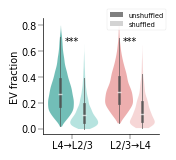

In [29]:
from matplotlib import collections
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
import seaborn as sns
import matplotlib.pyplot as plt

fontsize=7
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.violinplot(data=melted_mouse_df, x=x, y=y, 
            hue=hue, order=order,hue_order=hue_order,
            linewidth=0, gap=-0.2, width=0.8, inner='box', palette=['gray','lightgray'],
            inner_kws={'box_width':2, 'alpha':0.7, 'markersize':3, 'markeredgewidth':1},
            saturation=1,cut=0)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles, labels=['unshuffled', 'shuffled'], fontsize=6*0.8, loc=(0.55,0.9))
legend.get_frame().set_linewidth(0.2)
ax.tick_params(axis='both', labelsize=fontsize, pad=1, width=0.3)
ax.set_xlabel(None)
ax.set_ylabel(y, fontsize=fontsize, labelpad=1)
sns.despine()

custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)
ax.spines[:].set_linewidth(0.5)

add_stars_2_sets(melted_mouse_df, neuron_property=y, 
hue=hue, ax=ax, fontsize=fontsize,x=x, x_order=order,height1=0.8, height2=0.8, perm_type='paired', hierarchical=True)
plot_null_line(df_mouse_null, neuron_property='EV', ax=ax)
plt.show()

In [30]:
df_mouse_ = make_mouse_df_time(mouse_stats).query('control_shuffle==False')[['Dataset Type', 'Mouse', 'Mouse Name', 'Area', 'Direction', 'EV','1-vs-rest r²',
       'Neuron', 'EV shuffled', 'Activity Type']]
df_mouse_spont = make_mouse_df_time(mouse_stats, dataset_types=['ori32_spont','natimg32_spont']).query('control_shuffle==False')[['Dataset Type', 'Mouse', 'Mouse Name', 'Area', 'Direction', 'EV','1-vs-rest r²',
       'Neuron', 'EV shuffled', 'Activity Type']]
df_mouse_spont_ =df_mouse_spont.rename(columns={'EV':'EV gray screen','EV shuffled':'EV shuffled gray screen' })
df_mouse_resp_spont = pd.merge(df_mouse_, df_mouse_spont_, on=['Mouse', 'Mouse Name', 'Area', 'Direction','1-vs-rest r²',
       'Neuron'])
df_mouse_resp_spont_sorted = df_mouse_resp_spont.sort_values('EV gray screen')

In [31]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
colors = ['#ddf2f0', '#55C0B7', '#112624']
norm = Normalize(vmin=0, vmax=1)
v4_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
colors = ['#FFE8E8', '#F58B8E', '#551312']
v1_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

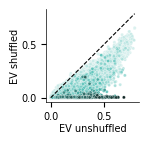

In [35]:
area='L2/3'
palette=v4_cmap

fontsize=7
line_color='black'
x= 'EV'
y='EV shuffled'
hue='EV gray screen'

fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area],
x=x, y=y, hue=hue, palette=palette, s=5)

ev_max = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].max()
ev_shuffled_max= df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].max()
ev_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].min()
ev_shuffled_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].min()

legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':fontsize*0.8})
legend.get_frame().set_linewidth(0.2)

ax.plot([0, max(ev_max,ev_shuffled_max)], [0,max(ev_max, ev_shuffled_max)],color=line_color, linestyle='--', linewidth=0.8)
ax.spines[:].set_linewidth(0.5)
sns.despine()
ax.legend_.remove()
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
plt.show()

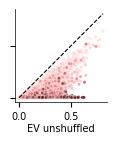

In [36]:
area='L4'
palette=v1_cmap

fontsize=7
line_color='black'
x= 'EV'
y='EV shuffled'
hue='EV gray screen'

fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area],
x=x, y=y, hue=hue, palette=palette, s=5)

ev_max = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].max()
ev_shuffled_max= df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].max()
ev_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][x].min()
ev_shuffled_min = df_mouse_resp_spont_sorted[df_mouse_resp_spont_sorted.Area==area][y].min()

legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel(None)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':fontsize*0.8})
legend.get_frame().set_linewidth(0.2)

ax.plot([0, max(ev_max,ev_shuffled_max)], [0,max(ev_max, ev_shuffled_max)],color=line_color, linestyle='--', linewidth=0.8)
ax.spines[:].set_linewidth(0.5)
sns.despine()
ax.legend_.remove()
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5], labels=[])
plt.show()

## Monkey Shuffle Trial Repeats

In [38]:
from macaque_data_functions import get_get_condition_type
all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

In [ ]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates,get_max_corr_vals_monkey_all_dates,get_evar_monkey_all_dates,get_one_vs_rest_r_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25)

get_evar_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

In [ ]:
from macaque_data_functions import get_resps
start_time = time.time()

dates = monkey_stats['SNR'].keys()
frames_to_reduce=5
n_splits=10
area='V4'
area2='V1'
w_size=25
alphas=[ 500.,  1000., 5000., 10000.,5e4]
for condition_type in ['SNR','SNR_spont']:
    for date in monkey_stats[condition_type]:
        get_condition_type = get_get_condition_type(condition_type)
        resp_V4_shuffled, resp_V1=get_resps(condition_type=get_condition_type, date=date, shuffle=True,
                                    w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type])
        alpha, evars = get_best_alpha_evars(resp_V1, resp_V4_shuffled, n_splits=n_splits,
                                        frames_reduced=frames_to_reduce, alphas=alphas)
        alpha2, evars2 = get_best_alpha_evars(resp_V4_shuffled, resp_V1, n_splits=n_splits,
                                        frames_reduced=frames_to_reduce, alphas=alphas)
        monkey_stats[condition_type][date][area]['alpha_shuffled']=alpha
        monkey_stats[condition_type][date][area2]['alpha_shuffled']=alpha2
        monkey_stats[condition_type][date][area]['evar_shuffled_istims']=evars
        monkey_stats[condition_type][date][area2]['evar_shuffled_istims']=evars2
    
    print(condition_type, 'done')
end_time = time.time()
# Calculate the elapsed time
elapsed_time = (end_time - start_time)/60
print(f'yay! date {date} for {condition_type} is completed')
print(f'Took {elapsed_time:.4f} minutes to complete') 

### plotting

In [61]:
df_ = make_monkey_df_time(monkey_stats)
df = df_[(df_['SNR']>2)&(df_['split-half r']>0.8)]
melted_df = df.melt(id_vars=['Date', 'Area','Activity Type'], 
                    value_vars=['EV', 'EV shuffled', 'control shuffle EV'], 
                    var_name='Analysis Type', 
                    value_name='Value')

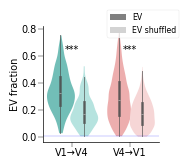

In [62]:
fontsize=7
areas = ['V4','V1']
from matplotlib import collections
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.violinplot(data=melted_df, x='Area', y='Value', 
            hue='Analysis Type', order=['V4', 'V1'],hue_order=['EV', 'EV shuffled'],
            linewidth=0, gap=-0.2, width=0.8, inner='box', palette=['gray','lightgray'],
            inner_kws={'box_width':2, 'alpha':0.7},
            saturation=1,cut=0)
legend = ax.legend(fontsize=fontsize*0.8, loc=(0.55,0.9))
legend.get_frame().set_linewidth(0.2)
xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticks(ticks=ax.get_xticks(), labels=['V1→V4', 'V4→V1'], fontsize=6)
ax.set_ylabel('EV fraction', fontsize=fontsize, labelpad=1)
ax.set(xlabel=None)
ax.tick_params(axis='both', labelsize=fontsize, pad=1, width=0.3)
sns.despine()
custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)
ax.spines[:].set_linewidth(0.5)
add_stars_2_sets(melted_df[melted_df['Analysis Type'].isin(['EV', 'EV shuffled'])], neuron_property='Value',
hue='Analysis Type', ax=ax, fontsize=fontsize, x='Area', x_order=['V4', 'V1'],height1=0.8, height2=0.8, perm_type='paired')
plot_null_line(df, neuron_property='control shuffle EV', ax=ax)
plt.show()

In [66]:
df_ = make_monkey_df_time(monkey_stats,dataset_types=['SNR'])
df_spont=make_monkey_df_time(monkey_stats, dataset_types=['SNR_spont'])
df_spont_ =df_spont.rename(columns={'Activity Type':'Activity Type spont','EV':'EV gray screen', 'EV shuffled':'EV shuffled gray screen','Max Corr Vals':'Max Corr Val Spont','null_shuffled': 'null_shuffled spont',
'Coeff Val':'Coeff Val spont'})               
df_both = pd.merge(df_, df_spont_, on=['Date', 'Area', 'SNR', 'split-half r','1-vs-rest r²'])
df_both_sorted = df_both.sort_values('EV gray screen')

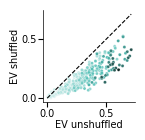

In [68]:
fontsize=7
area='V4'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV gray screen', palette=v4_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.legend_.remove()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
plt.show()


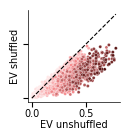

In [70]:
fontsize=7
area='V1'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV gray screen', palette=v1_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV gray screen',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.legend_.remove()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5], labels=[])
plt.show()


### supplemental

In [110]:
df_ = make_monkey_df_time(monkey_stats, dataset_types=['SNR_spont'])
df = df_[(df_['SNR']>2)&(df_['split-half r']>0.8)]
melted_df = df.melt(id_vars=['Date', 'Area','Activity Type'], 
                    value_vars=['EV', 'EV shuffled', 'control shuffle EV'], 
                    var_name='Analysis Type', 
                    value_name='Value')

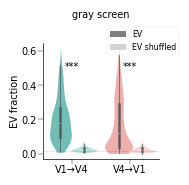

In [112]:
fontsize=7
areas = ['V4','V1']
from matplotlib import collections
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
fig, ax = plt.subplots(figsize=(1.5,1.5))
sns.violinplot(data=melted_df, x='Area', y='Value', 
            hue='Analysis Type', order=['V4', 'V1'],hue_order=['EV', 'EV shuffled'],
            linewidth=0, gap=-0.2, width=0.8, inner='box', palette=['gray','lightgray'],
            inner_kws={'box_width':2, 'alpha':0.7},
            saturation=1,cut=0)
legend = ax.legend(fontsize=fontsize*0.8, loc=(0.55,0.9))
legend.get_frame().set_linewidth(0.2)
xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticks(ticks=ax.get_xticks(), labels=['V1→V4', 'V4→V1'], fontsize=6)
ax.set_ylabel('EV fraction', fontsize=fontsize, labelpad=1)
ax.set(xlabel=None)
ax.tick_params(axis='both', labelsize=fontsize, pad=1, width=0.3)
sns.despine()
custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE', '#f6d6d6']
violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
for violin, color in zip(violins, custom_colors):
    violin.set_facecolor(color)
ax.spines[:].set_linewidth(0.5)
add_stars_2_sets(melted_df[melted_df['Analysis Type'].isin(['EV', 'EV shuffled'])], neuron_property='Value',
hue='Analysis Type', ax=ax, fontsize=fontsize, x='Area', x_order=['V4', 'V1'],height1=0.8, height2=0.8, perm_type='paired')
plot_null_line(df, neuron_property='control shuffle EV', ax=ax)
ax.set_title('gray screen', fontsize=fontsize, x=0.5, y=1.15)
plt.show()

In [120]:
df = make_monkey_df_time(monkey_stats,dataset_types=['SNR'])
df_spont_=make_monkey_df_time(monkey_stats, dataset_types=['SNR_spont'])
df_ =df.rename(columns={'Activity Type':'Activity Type stimulus','EV':'EV stimulus', 'EV shuffled':'EV shuffled stimulus','Max Corr Vals':'Max Corr Val stim','null_shuffled': 'null_shuffled stim',
'Coeff Val':'Coeff Val stim'})               
df_both = pd.merge(df_, df_spont_, on=['Date', 'Area', 'SNR', 'split-half r','1-vs-rest r²'])
df_both_sorted = df_both.sort_values('EV stimulus')

In [121]:
df_both_sorted.columns

Index(['Dataset Type_x', 'Activity Type stimulus', 'Date', 'Area',
       'Direction_x', 'EV stimulus', 'SNR', 'split-half r', 'max r² val_x',
       '1-vs-rest r²', 'control_shuffle_x', 'EV shuffled stimulus',
       'control shuffle EV_x', 'Dataset Type_y', 'Activity Type',
       'Direction_y', 'EV', 'max r² val_y', 'control_shuffle_y', 'EV shuffled',
       'control shuffle EV_y'],
      dtype='object')

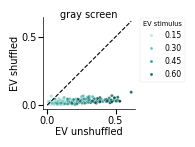

In [123]:
fontsize=7
area='V4'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV stimulus', palette=v4_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV stimulus',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
ax.set_title('gray screen', fontsize=fontsize, x=0.5, y=0.9)
plt.show()


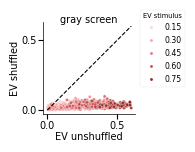

In [124]:
fontsize=7
area='V1'
line_color='black'
fig, ax=plt.subplots(figsize=(1.2,1.2))
sns.scatterplot(data=df_both_sorted[df_both_sorted.Area==area],
x='EV', y='EV shuffled', hue='EV stimulus', palette=v1_cmap, s=5)
ev_max = df_both_sorted[df_both_sorted.Area==area]['EV'].max()
max_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].max()
ev_min = df_both_sorted[df_both_sorted.Area==area]['EV'].min()
min_val = df_both_sorted[df_both_sorted.Area==area]['EV shuffled'].min()
legend = ax.legend(loc=(1.05,0.3),fontsize=fontsize*0.8)
ax.tick_params(axis='both', labelsize=fontsize, pad=1)
ax.set_ylabel('EV shuffled', fontsize=fontsize, labelpad=1)
ax.set_xlabel('EV unshuffled', fontsize=fontsize, labelpad=1)
ax.set_aspect('equal')
legend.set_title(title='EV stimulus',prop={'size':6*0.8})
legend.get_frame().set_linewidth(0.2)
ax.plot([0, ev_max], [0,ev_max],color=line_color, linestyle='--', linewidth=0.8)
sns.despine()
ax.spines[:].set_linewidth(0.5)
ax.set_xticks([0,0.5])
ax.set_yticks([0,0.5])
ax.set_title('gray screen', fontsize=fontsize, x=0.5, y=0.9)
plt.show()


## Monkey timewindows offset

In [ ]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates,get_max_corr_vals_monkey_all_dates,get_evar_monkey_all_dates,get_one_vs_rest_r_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)
get_one_vs_rest_r_monkey_all_dates(monkey_stats, w_size=25)

get_evar_monkey_all_dates(monkey_stats)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)
store_V1_indices(monkey_stats)

In [ ]:
ref_duration = 200
w_size=25
ref_area = 'V4'

condition_types = ['SNR','SNR_spont']
for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        process_timelag_shenanigans(condition_type, date, ref_area, ref_duration, 
                                monkey_stats, w_size, control_neurons=True)

In [ ]:
ref_area = 'V1'

condition_types = ['SNR','SNR_spont']
for condition_type in condition_types:
    for date in monkey_stats[condition_type]:
        process_timelag_shenanigans(condition_type, date, ref_area, ref_duration, 
                                monkey_stats, w_size, control_neurons=True)

### plotting

In [104]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define your custom colormap colors (e.g., dark blue to light blue)
colors = ['white', '#55C0B7', '#054C47']
# Normalize the colormap between 0 and 1 (adjust as needed for your data)
norm = Normalize(vmin=0, vmax=1)
# Create the custom colormap
v4_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)


ref_area='V4'
ref_duration=200
w_size=25
condition_type='SNR'
ref_ons, ref_offs = get_refons_refoffs(ref_duration, w_size, condition_type)
df_v4_ = make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)




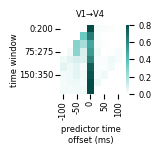

In [105]:

df_v4 = df_v4_[df_v4_['Offset(ms)'].isin([   0,   25,   50,   75,  100, -25,  -50,
        -75, -100])]
max_value_indices = df_v4.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v4.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v4.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v4.Ref_Times.unique())


fig, ax = plt.subplots(figsize=(1,0.9))

sns.heatmap(data, cmap=v4_cmap, vmin=0, vmax=0.8)
ax.tick_params(axis='both', labelsize=6, pad=1)
ax.set_ylabel('time window', fontsize=6, labelpad=0)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)

# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}', fontsize=6)
plt.show()

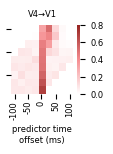

In [109]:
colors = ['white', '#F58B8E', '#94221F']
# Create the custom colormap
v1_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

ref_area='V1'
ref_duration=200
w_size=25
condition_type='SNR'
ref_ons, ref_offs = get_refons_refoffs(ref_duration, w_size, condition_type)
df_v1_ = make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)


df_v1 = df_v1_[df_v1_['Offset(ms)'].isin([   0,   25,   50,   75,  100, -25,  -50,
        -75, -100])]
max_value_indices = df_v1.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v1.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v1.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v1.Ref_Times.unique())

fig, ax = plt.subplots(figsize=(1,0.9))
sns.heatmap(data, cmap=v1_cmap, vmin=0,vmax=0.8)
ax.tick_params(axis='both', labelsize=6, pad=1)
ax.set_ylabel(None)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)
# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
ax.set_yticklabels('')

if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}', fontsize=6)
plt.show()

### supplemental

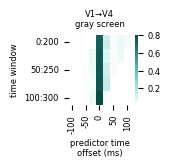

In [126]:
ref_area='V4'
fig, ax = plt.subplots(figsize=(1,0.9))

condition_type='SNR_spont'
ref_ons, ref_offs = get_refons_refoffs(ref_duration, w_size, condition_type)


df_v4= make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)
max_value_indices = df_v4.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v4.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v4.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v4.Ref_Times.unique())
sns.heatmap(data, cmap=v4_cmap, vmax=0.8)
ax.tick_params(axis='both', labelsize=6)
ax.set_ylabel('time window', fontsize=6)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)
# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}\ngray screen', fontsize=6)
plt.show()

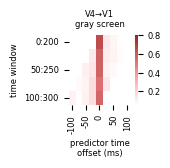

In [129]:
ref_area='V1'
fig, ax = plt.subplots(figsize=(1,0.9))
df_v1= make_df_timelags(monkey_stats, condition_type, ref_area, ref_ons,ref_offs, ref_duration, control_neurons=True)

max_value_indices = df_v1.groupby(['Ref_Times','SNR','split-half r','Permutation'])['EV'].idxmax()
heatmap_data_max = df_v1.loc[max_value_indices].pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
heatmap_data_all = df_v1.pivot_table(index='Ref_Times', columns='Offset(ms)', values='EV', aggfunc='count')
data =heatmap_data_max/heatmap_data_all
data = data.reindex(df_v1.Ref_Times.unique())
sns.heatmap(data, cmap=v1_cmap, vmax=0.8)
ax.tick_params(axis='both', labelsize=6)
ax.set_ylabel('time window', fontsize=6)
ax.set_xlabel('predictor time\noffset (ms)', fontsize=6)
# Access the colorbar and set fontsize of ticks
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=6)
if ref_area=='V4':
    predictor_area='V1'
elif ref_area=='V1':
    predictor_area='V4'
ax.set_xticks([0.5,2.5,4.4,6.5,8.5], labels=[-100,-50,0,50,100])
plt.title(f'{predictor_area}→{ref_area}\ngray screen', fontsize=6)
plt.show()

In [154]:
from joblib import Parallel, delayed
import time
from tqdm import tqdm

start_time = time.time()

condition_types=['SNR','SNR_spont','RS']
timebin=25
date = list(monkey_stats[condition_type].keys())[0]
timebins = [1, 10, 25, 50]
results = Parallel(n_jobs=7)(delayed(make_raw_data_df)(condition_type,date,timebin) for condition_type in condition_types)
df_ = pd.DataFrame([])
for data in results:
    df_2 = pd.DataFrame(data)
    df_= pd.concat([df_, df_2])
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Took {elapsed_time:.4f} minutes to complete')

Took 0.2317 minutes to complete


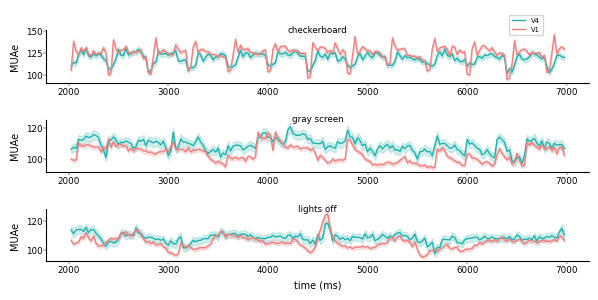

In [155]:
condition_type='SNR'
n_rows = 3
n_columns = 1
fontsize=7
reduce_factor=1
fig, axes = plt.subplots(n_rows,n_columns, figsize=(n_columns*7*reduce_factor, n_rows*reduce_factor))
for a, (ax, condition_type) in enumerate(zip(axes.flatten(), condition_types)):
    
    sns.lineplot(data=df_[(df_['time']>2000)&(df_['time']<7000)&(df_['timebin']==timebin)&(df_['Dataset_Type']==condition_type)], 
            x='time',y='MUAe', hue='Area', ax=ax, errorbar='se', 
            palette=['lightseagreen','lightcoral'], linewidth=1)
    if 'spont' in condition_type:
        cond_label = 'gray screen'
    elif 'RS' in condition_type:
        cond_label = 'lights off'
    elif 'SNR' in condition_type:
        cond_label = 'checkerboard'
    else:
        cond_label = 'unknown'
    ax.set_title(f'{cond_label}', y=0.8, fontsize=fontsize*.9)
    ax.legend_.remove()
    ax.xaxis.get_label().set_fontsize(fontsize)
    ax.yaxis.get_label().set_fontsize(fontsize)
    ax.tick_params(axis='both', labelsize=fontsize*.9, width=0.3, length=2, pad=1)

    if a!=2:
        ax.set_xlabel(None)
    else:
        ax.set_xlabel('time (ms)')
    sns.despine()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85,0.88), fontsize=fontsize*0.7)
fig.subplots_adjust(hspace=1)
# fig.suptitle(f'{condition_type} {date}',x=0.5,y=1, fontsize=fontsize)
plt.subplots_adjust(wspace=0.15,hspace=0.7)

